### Importaci√≥n de Librer√≠as necesarias

In [1]:
import os
import zipfile
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Masking, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

### 1. Importaci√≥n de datos desde Github (Datos tomados con Edge Impulse)

Descarga y descompresi√≥n de un archivo .zip desde el repositorio de GitHub. El archivo contiene los datos recolectados mediante Edge Impulse, que ser√°n utilizados posteriormente para entrenar modelos de clasificaci√≥n de series de tiempo.

In [3]:
# URL del archivo ZIP en GitHub que contiene los datos exportados desde Edge Impulse
GITHUB_URL = "https://github.com/DCajiao/Time-Series-Classification-with-Recurrent-Networks/raw/main/data/zip/dcajiao-project-1-export.zip"

# Nombre local con el que se guardar√° el archivo ZIP una vez descargado
zip_path = "dcajiao-project-1-export.zip"

try:
    # Realiza una petici√≥n HTTP para descargar el contenido del archivo desde GitHub
    response = requests.get(GITHUB_URL)

    # Guarda el contenido descargado en un archivo ZIP localmente
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Descomprime el archivo ZIP en una carpeta llamada 'data'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("data")  # Extrae todos los archivos en la ruta especificada
        print("Archivo descargado y descomprimido en la carpeta 'data'.")

# Captura cualquier error que ocurra durante la descarga o descompresi√≥n e imprime el mensaje
except Exception as e:
    print(f"Error al descargar o descomprimir el archivo: {e}")


Archivo descargado y descomprimido en la carpeta 'data'.


### 2. Carga de Datos

1. **Lectura de archivos `.labels`** generados por Edge Impulse, que contienen informaci√≥n sobre las muestras recolectadas.
2. **Funci√≥n `load_samples()`**:

   * Lee cada muestra `.json` asociada a su etiqueta.
   * Convierte las secuencias de datos en arreglos NumPy.
   * Mapea las etiquetas de texto a enteros para facilitar el entrenamiento del modelo.
3. **Carga y organizaci√≥n de datos de entrenamiento y prueba**, devolviendo los tensores y el mapeo de clases.


In [4]:
# Cargar las etiquetas para el conjunto de entrenamiento desde el archivo .labels (formato JSON)
with open("data/training/info.labels", "r") as f:
    training_info = json.load(f)

# Cargar las etiquetas para el conjunto de prueba
with open("data/testing/info.labels", "r") as f:
    testing_info = json.load(f)

# Mostrar el n√∫mero de entradas por conjunto
print(f"Entradas de entrenamiento: {len(training_info['files'])}")
print(f"Entradas de prueba: {len(testing_info['files'])}")


Entradas de entrenamiento: 60
Entradas de prueba: 20


In [5]:
def load_samples(label_info, base_path="data"):
    data = []          # Lista para almacenar las series temporales (arrays)
    labels = []        # Lista para almacenar las etiquetas (enteros)
    label_map = {}     # Diccionario para mapear etiqueta textual a entero
    label_counter = 0  # Contador para asignar enteros √∫nicos a cada etiqueta

    for file_info in label_info["files"]:
        category = file_info["category"]      # Carpeta espec√≠fica (training/testing)
        filename = file_info["path"]          # Nombre del archivo JSON
        label_str = file_info["label"]["label"]  # Etiqueta textual de la muestra
        file_path = os.path.join(base_path, category, filename)  # Ruta absoluta del archivo

        # Si la etiqueta no ha sido registrada, se le asigna un entero nuevo
        if label_str not in label_map:
            label_map[label_str] = label_counter
            label_counter += 1

        # Abrir y cargar los datos del archivo JSON
        with open(file_path, "r") as f:
            sample = json.load(f)

            try:
                # Extraer los valores de la serie temporal del campo 'payload'
                values = sample["payload"]["values"]
                values_np = np.array(values, dtype=np.float32)  # Convertir a NumPy array
                data.append(values_np)
                labels.append(label_map[label_str])  # A√±adir etiqueta mapeada
            except KeyError:
                print(f"Error de formato en archivo: {file_path}")

    return np.array(data, dtype=object), np.array(labels), label_map  # dtype=object por distintas longitudes

# Cargar datos y etiquetas de entrenamiento
X_train, y_train, label_map = load_samples(training_info)

# Cargar datos y etiquetas de prueba
X_test, y_test, _ = load_samples(testing_info)

# Mostrar informaci√≥n general
print("Etiquetas:", label_map)
print("Tama√±o total de muestras:", len(X_train))
print("Forma ejemplo:", X_train[0].shape)  # Muestra la forma del primer ejemplo


Etiquetas: {'squat': 0, 'biceps_flexion': 1, 'wrist_rotation': 2, 'hello_with_hand': 3}
Tama√±o total de muestras: 60
Forma ejemplo: (625, 3)


Esto nos indica que:

* Hay 4 clases de movimientos.
* Cada muestra tiene 625 pasos temporales y 3 caracter√≠sticas (eje X, Y, Z del aceler√≥metro).

### 3. An√°lisis Inicial de las clases

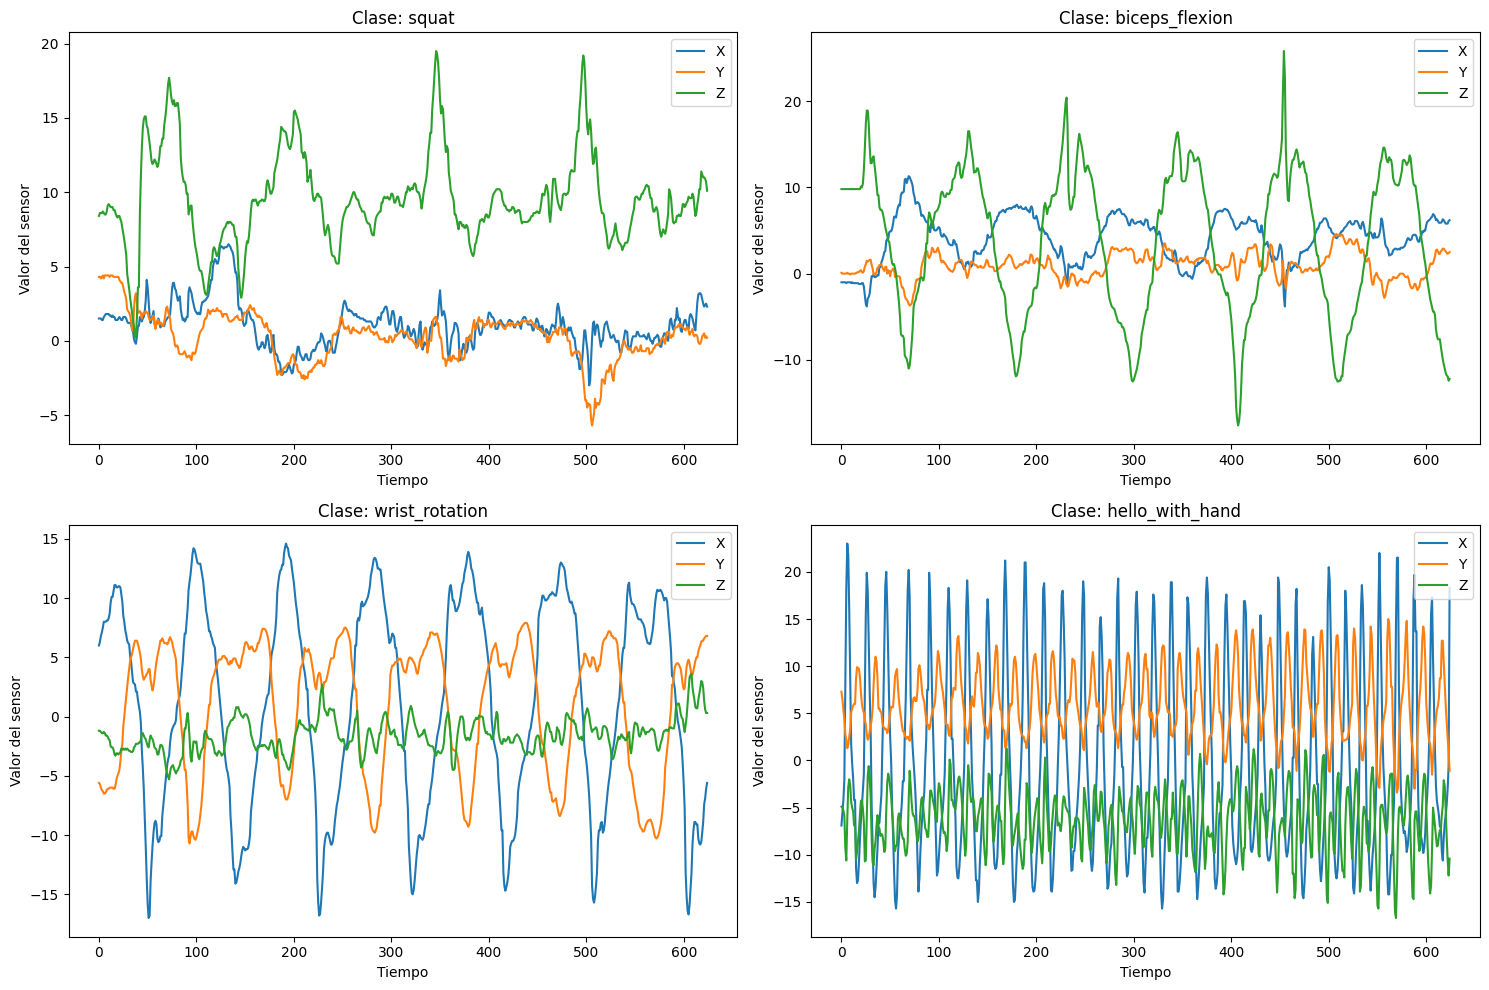

In [6]:
# Funci√≥n para graficar una muestra por clase
def plot_sample_by_class(X, y, label_map):
    inv_label_map = {v: k for k, v in label_map.items()}  # Revertir mapeo para mostrar etiquetas
    plt.figure(figsize=(15, 10))

    # Seleccionar una muestra por cada clase
    for class_id in np.unique(y):
        idx = np.where(y == class_id)[0][0]  # primer √≠ndice con esa etiqueta
        sample = X[idx]

        plt.subplot(2, 2, class_id + 1)
        plt.plot(sample[:, 0], label="X")
        plt.plot(sample[:, 1], label="Y")
        plt.plot(sample[:, 2], label="Z")
        plt.title(f"Clase: {inv_label_map[class_id]}")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor del sensor")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecutar la funci√≥n con los datos cargados
plot_sample_by_class(X_train, y_train, label_map)


#### üìä **Interpretaci√≥n de la gr√°fica por clase**

1. **Clase: `squat`**

* El eje **Z** (verde) presenta picos prominentes, lo que indica una fuerte variaci√≥n vertical ‚Äîcoherente con el movimiento de sentadilla.
* Los ejes **X** y **Y** permanecen m√°s estables, con peque√±as fluctuaciones.
* Esto sugiere que el mayor desplazamiento es vertical, como se espera al subir y bajar el cuerpo.

2. **Clase: `biceps_flexion`**

* El eje **Z** muestra un patr√≥n oscilante moderado, posiblemente asociado con el levantamiento y bajada del antebrazo.
* El eje **X** tambi√©n var√≠a de forma constante, indicando que hay movimiento en el plano frontal.
* En conjunto, se observan ciclos suaves t√≠picos del movimiento repetitivo de flexi√≥n del brazo.

3. **Clase: `wrist_rotation`**

* Se aprecian patrones **muy c√≠clicos y sinusoidales** en los ejes **X** y **Y**, caracter√≠sticos de una rotaci√≥n.
* El eje **Z** se mantiene relativamente plano, lo cual tiene sentido: el giro de mu√±eca ocurre principalmente en un plano perpendicular al eje Z.
* Es la se√±al m√°s peri√≥dica del conjunto, ideal para ser reconocida por un modelo RNN o LSTM.

4. **Clase: `hello_with_hand`**

* Hay **fluctuaciones muy r√°pidas y frecuentes** en los tres ejes, en especial en **X**, lo que sugiere un gesto r√°pido de saludo lateral.
* Es la se√±al m√°s ruidosa visualmente, lo que puede representar un reto mayor de clasificaci√≥n.
* La alta frecuencia y amplitud sugieren un gesto vibratorio o de vaiv√©n.

---
Cada clase tiene un **perfil temporal distintivo**, lo cual es una condici√≥n excelente para entrenar una red neuronal recurrente. La gr√°fica confirma que:

* Hay **consistencia dentro de clases** (formas repetitivas),
* Y hay **diferenciaci√≥n entre clases** (formas visuales √∫nicas por tipo de movimiento).


----

### 4. Normalizaci√≥n de los datos

1. **Normalizaci√≥n independiente por eje (X, Y, Z)** para homogeneizar las magnitudes de las se√±ales.
2. **Relleno (`padding`)** para estandarizar las secuencias a una longitud com√∫n (`max_seq_len`), necesario para las RNN.
3. **Conversi√≥n final de etiquetas** para asegurar compatibilidad con el modelo.

Este preprocesamiento garantiza que los datos est√©n listos para ser alimentados a la red neuronal.

In [7]:
# Paso 1: Encuentra la longitud m√°xima de las secuencias
max_seq_len = max([x.shape[0] for x in X_train])

# Paso 2: Normaliza cada eje (X, Y, Z) independientemente para todas las secuencias
def normalize_sequences(sequences):
    # Unifica todos los datos en un solo array 2D para calcular media y desviaci√≥n est√°ndar global por eje
    all_data = np.concatenate(sequences, axis=0)

    # Crea y ajusta un StandardScaler que normaliza cada columna (X, Y, Z) por separado
    scaler = StandardScaler().fit(all_data)

    # Aplica la normalizaci√≥n a cada secuencia por separado
    return [scaler.transform(seq) for seq in sequences]

# Aplicar normalizaci√≥n a las secuencias de entrenamiento y prueba
X_train_norm = normalize_sequences(X_train)
X_test_norm = normalize_sequences(X_test)

# Paso 3: Rellenar las secuencias para que todas tengan la misma longitud
# Esto es necesario porque las RNN requieren secuencias de igual tama√±o
X_train_pad = pad_sequences(X_train_norm, maxlen=max_seq_len, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test_norm, maxlen=max_seq_len, padding='post', dtype='float32')

### 5. RNN Simple

Se construye una red neuronal recurrente secuencial con las siguientes caracter√≠sticas:
  * Se emplea una capa `Masking` para ignorar valores de **padding** (cero) en las secuencias, lo que permite procesar entradas de longitud variable.
  * La **primera capa `SimpleRNN`** tiene 64 unidades y retorna una secuencia completa (`return_sequences=True`) para que la siguiente capa pueda seguir procesando la informaci√≥n temporal.
  * Se a√±ade `BatchNormalization` para estabilizar y acelerar el proceso de entrenamiento al normalizar la activaci√≥n de la capa anterior.
  * La **segunda capa `SimpleRNN`** con 32 unidades reduce la secuencia completa a una √∫nica representaci√≥n (vector), capturando la informaci√≥n relevante para la clasificaci√≥n.
  * Se incorpora una capa `Dropout` con 20% de desactivaci√≥n aleatoria de neuronas, como t√©cnica de regularizaci√≥n para evitar el overfitting.
  * La **capa de salida `Dense`** utiliza una funci√≥n de activaci√≥n `softmax` para realizar clasificaci√≥n multiclase, con tantas neuronas como clases (`len(label_map)`).
  * El modelo se compila usando el optimizador `Adam` con recorte de gradiente (`clipnorm=1.0`) para mejorar la estabilidad del entrenamiento.
  * La funci√≥n de p√©rdida es `sparse_categorical_crossentropy`, adecuada para etiquetas codificadas como enteros.



In [8]:
# Crear el modelo secuencial de RNN simple
model_rrn_simple = Sequential([
    # Ignora pasos con valor cero (usado en el padding de secuencias m√°s cortas)
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa recurrente: procesa la secuencia completa y entrega otra secuencia
    SimpleRNN(64, return_sequences=True),

    # Normalizaci√≥n por lotes: estabiliza el aprendizaje y mejora la convergencia
    BatchNormalization(),

    # Segunda capa recurrente: resume la secuencia anterior a una √∫nica representaci√≥n
    SimpleRNN(32),

    # Capa Dropout: desactiva el 20% de las neuronas aleatoriamente durante el entrenamiento (regularizaci√≥n)
    Dropout(0.2),

    # Capa de salida: tantas neuronas como clases, activaci√≥n softmax para clasificaci√≥n
    Dense(len(label_map), activation='softmax')
])

# Compilaci√≥n del modelo: Adam es un optimizador eficiente para este tipo de problemas
optimizer = Adam(clipnorm=1.0)
model_rrn_simple.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # P√©rdida adecuada cuando las etiquetas son enteros
    metrics=['accuracy']
)

# Resumen del modelo: muestra la arquitectura y n√∫mero de par√°metros entrenables
model_rrn_simple.summary()

c:\Users\david\Desktop\Time-Series-Classification-with-Recurrent-Networks\.venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ masking (Masking)               ‚îÇ (None, 625, 3)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn (SimpleRNN)          ‚îÇ (None, 625, 64)        ‚îÇ         4,352 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 625, 64)        ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_1 (SimpleRNN)        ‚îÇ (None, 32)             ‚îÇ         3,104 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 4)              ‚îÇ           132 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 7,844 (30.64 KB)

 Trainable params: 7,716 (30.14 KB)

 Non-trainable params: 128 (512.00 B)

* Se entrena el modelo RNN simple con los siguientes ajustes:

  * Se usa el callback `EarlyStopping` para **detener el entrenamiento autom√°ticamente** si la p√©rdida de validaci√≥n (`val_loss`) no mejora durante 3 √©pocas consecutivas. Adem√°s, se restauran los **mejores pesos** del modelo al final del entrenamiento para evitar sobreajuste.
  
  * El modelo se entrena usando:
    - `X_train_pad` como entrada (ya con padding aplicado para igualar longitudes de secuencia).
    - `y_train` como etiquetas de clase codificadas como enteros.
    - Validaci√≥n contra el conjunto `X_test_pad` y `y_test` para monitorear el desempe√±o generalizado del modelo.
  
  * Configuraci√≥n adicional del entrenamiento:
    - `epochs=50`: m√°ximo n√∫mero de √©pocas permitidas.
    - `batch_size=4`: tama√±o de lote peque√±o, adecuado para datos secuenciales y tama√±os de dataset moderados.
    - `callbacks=[early_stop]`: evita entrenamiento innecesario si no hay mejoras.
    - `verbose=1`: muestra el progreso detallado del entrenamiento.
    - `shuffle=True`: mezcla aleatoriamente las muestras en cada √©poca para evitar que el modelo aprenda patrones del orden de los datos.


In [9]:
# Callback para detener el entrenamiento si la p√©rdida de validaci√≥n no mejora despu√©s de 10 √©pocas
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rrn_simple.fit(
    X_train_pad,         # Conjunto de entrenamiento ya con padding aplicado
    y_train,             # Etiquetas correspondientes
    validation_data=(X_test_pad, y_test),  # Datos de validaci√≥n
    epochs=50,          # N√∫mero m√°ximo de √©pocas
    batch_size=4,        # Tama√±o de lote reducido por naturaleza secuencial del modelo
    callbacks=[early_stop],  # Se detendr√° autom√°ticamente si no mejora
    verbose=1,            # Muestra el progreso del entrenamiento
    shuffle=True    # Barajar los datos para evitar patrones en el entrenamiento
)

Epoch 1/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 199ms/step - accuracy: 0.2219 - loss: 1.5670 - val_accuracy: 0.5000 - val_loss: 1.1621
Epoch 2/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 170ms/step - accuracy: 0.4915 - loss: 1.0836 - val_accuracy: 0.4500 - val_loss: 1.1777
Epoch 3/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 167ms/step - accuracy: 0.5937 - loss: 0.9789 - val_accuracy: 0.5500 - val_loss: 1.0624
Epoch 4/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 164ms/step - accuracy: 0.4726 - loss: 1.1701 - val_accuracy: 0.6500 - val_loss: 0.9504
Epoch 5/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 167ms/step - accuracy: 0.4610 - loss: 1.1159 - val_accuracy: 0.5500 - val_loss: 0.9729
Epoch 6/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 167ms/step - accuracy: 0.6066 - loss: 1.0099 - val_accuracy: 0.6500 - val_loss:

---
* Se eval√∫a el desempe√±o del modelo RNN simple sobre el conjunto de prueba:

  * `model_rrn_simple.evaluate(...)` calcula la **p√©rdida (`loss`)** y la **precisi√≥n (`accuracy`)** sobre `X_test_pad` y `y_test`.
  * El par√°metro `verbose=0` se utiliza para desactivar la salida detallada durante la evaluaci√≥n.
  * Los resultados se imprimen con 4 decimales para una visualizaci√≥n clara y profesional.


In [10]:
loss, accuracy = model_rrn_simple.evaluate(X_test_pad, y_test, verbose=0)
print(f"üîç Precisi√≥n en test: {accuracy:.4f} - P√©rdida: {loss:.4f}")

üîç Precisi√≥n en test: 0.6500 - P√©rdida: 0.8201


- Precisi√≥n del 65%: El modelo acierta en el 65% de las predicciones del conjunto de prueba, lo cual es un punto de partida razonable, pero a√∫n hay margen para mejoras.

- P√©rdida de 0.8201: Indica la discrepancia promedio entre las predicciones del modelo y las etiquetas reales. Un valor m√°s bajo sugiere mejores predicciones.

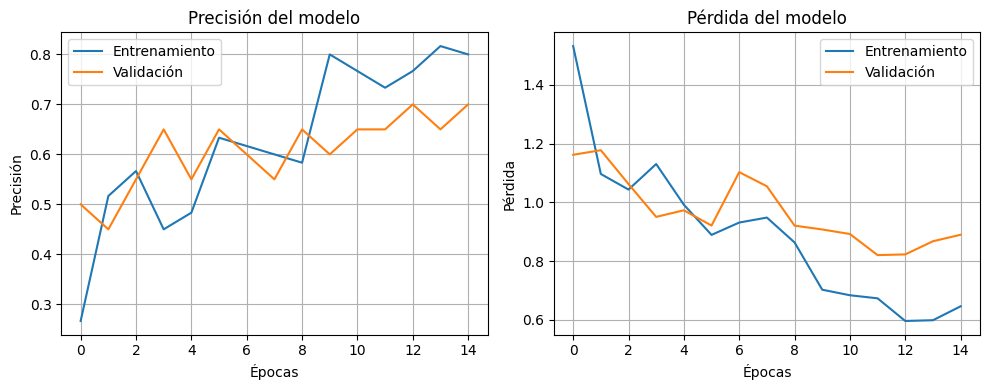

In [11]:
plt.figure(figsize=(10, 4))

# Precisi√≥n
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title('Precisi√≥n del modelo')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title('P√©rdida del modelo')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


üìä Interpretaci√≥n del Entrenamiento ‚Äì RNN Simple

Panel Izquierdo: **Precisi√≥n del Modelo (Accuracy)**

üîç Observaciones:

* La **precisi√≥n en entrenamiento** empieza baja (\~0.27), mejora de forma continua, y supera el **80% en las √∫ltimas √©pocas**.
* La **precisi√≥n en validaci√≥n** sigue una trayectoria ascendente m√°s moderada, alcanzando un valor estable de alrededor de **0.70**.
* Ambas curvas muestran una **tendencia coherente** sin grandes divergencias.

‚úÖ Conclusi√≥n:

* El modelo muestra un **proceso de aprendizaje progresivo** y consistente.
* Aunque la precisi√≥n en entrenamiento es mayor, la **precisi√≥n en validaci√≥n se mantiene estable y sin ca√≠das abruptas**, lo que sugiere una **buena generalizaci√≥n**.
* No se evidencia un **sobreajuste agresivo**, pero podr√≠a beneficiarse del uso de `EarlyStopping` para cortar el entrenamiento en el punto √≥ptimo.

---

Panel Derecho: **P√©rdida del Modelo (Loss)**

üîç Observaciones:

* La **p√©rdida en entrenamiento** cae con claridad desde \~1.5 hasta \~0.6, confirmando que el modelo est√° aprendiendo.
* La **p√©rdida en validaci√≥n** desciende de \~1.15 a \~0.85, con peque√±as oscilaciones, pero sin picos severos ni comportamientos err√°ticos.

---

‚úÖ Conclusi√≥n:

* El comportamiento de la p√©rdida refuerza la idea de **aprendizaje estable y efectivo**.
* La diferencia entre p√©rdida de entrenamiento y validaci√≥n en las √∫ltimas √©pocas no es cr√≠tica, pero podr√≠a controlarse con una capa adicional de regularizaci√≥n o ajustando el n√∫mero de √©pocas.

---


### 6. RNN LSTM

* Se define una red neuronal secuencial basada en **LSTM**, una arquitectura m√°s robusta que `SimpleRNN` para modelar **dependencias de largo plazo** en secuencias temporales. La red est√° compuesta por:

  * Una capa `Masking` que ignora los valores de padding (ceros), permitiendo al modelo procesar secuencias de longitud variable sin sesgar el aprendizaje.
  
  * Una **primera capa `LSTM` con 64 unidades**, configurada con `return_sequences=True`, lo que permite que la salida completa de la secuencia se pase a la siguiente capa.
  
  * Una capa `BatchNormalization`, que mejora la estabilidad del entrenamiento al normalizar las salidas de la capa LSTM anterior.

  * Una **segunda capa `LSTM` con 32 unidades**, que transforma la secuencia en una **representaci√≥n vectorial compacta** (√∫ltimo estado oculto).

  * Una capa `Dropout` con tasa 0.2, que ayuda a **prevenir overfitting** desactivando aleatoriamente el 20% de las unidades durante el entrenamiento.

  * Una **capa de salida `Dense` con activaci√≥n `softmax`**, utilizada para clasificaci√≥n multiclase. El n√∫mero de neuronas es igual al n√∫mero de clases (`len(label_map)`).

* El modelo se compila con el optimizador `Adam` usando `clipnorm=1.0` para evitar explosiones de gradiente, junto con la funci√≥n de p√©rdida `sparse_categorical_crossentropy` adecuada para etiquetas enteras.


In [12]:
# Paso 1: Definir el modelo LSTM
model_lstm = Sequential([
    # Igual que en el modelo anterior: ignora ceros de padding
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa LSTM que retorna una secuencia completa
    LSTM(64, return_sequences=True),

    # Normalizaci√≥n por lotes: estabiliza el aprendizaje
    BatchNormalization(),

    # Segunda capa LSTM que condensa la secuencia a un vector
    LSTM(32),

    # Regularizaci√≥n para evitar overfitting
    Dropout(0.2),

    # Capa de salida con softmax para clasificaci√≥n multiclase
    Dense(len(label_map), activation='softmax')
])

# Paso 2: Compilar el modelo con optimizador Adam
optimizer = Adam(clipnorm=1.0)
model_lstm.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen estructural del modelo
model_lstm.summary()


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ masking_1 (Masking)             ‚îÇ (None, 625, 3)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ (None, 625, 64)        ‚îÇ        17,408 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 625, 64)        ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 32)             ‚îÇ        12,416 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 4)              ‚îÇ           132 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 30,212 (118.02 KB)

 Trainable params: 30,084 (117.52 KB)

 Non-trainable params: 128 (512.00 B)

* Se entrena el modelo `LSTM` utilizando una estrategia similar al modelo `SimpleRNN`, con los siguientes elementos clave:

  * Se utiliza un callback `EarlyStopping` para **detener el entrenamiento anticipadamente** si la p√©rdida de validaci√≥n (`val_loss`) no mejora despu√©s de 3 √©pocas. Adem√°s, se activ√≥ `restore_best_weights=True` para garantizar que el modelo conserve los **pesos de la mejor √©poca** observada.

  * El modelo se entrena con:
    - `X_train_pad`: secuencias de entrada con padding aplicado.
    - `y_train`: etiquetas de clase como enteros.
    - `validation_data=(X_test_pad, y_test)`: datos separados para validar la generalizaci√≥n del modelo.

  * Hiperpar√°metros de entrenamiento:
    - `epochs=50`: se permiten hasta 50 √©pocas de entrenamiento como m√°ximo.
    - `batch_size=4`: tama√±o de lote reducido, ideal para datos secuenciales y con posibles variaciones temporales significativas.
    - `callbacks=[early_stop]`: evita el sobreentrenamiento al monitorear la p√©rdida de validaci√≥n.
    - `verbose=1`: muestra el progreso de cada √©poca.
    - `shuffle=True`: se mezcla el orden de los datos en cada √©poca para evitar que el modelo aprenda patrones artificiales del orden de los ejemplos.


In [13]:
# Paso 3: Entrenamiento del modelo LSTM
early_stop = EarlyStopping(
    monitor='val_loss',     # Se detiene si la p√©rdida de validaci√≥n no mejora
    patience=3,            # Espera 3 √©pocas sin mejora
    restore_best_weights=True  # Restaura los pesos √≥ptimos
)

# Entrenar la red
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=50,
    batch_size=4,
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)


Epoch 1/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 268ms/step - accuracy: 0.4618 - loss: 1.1233 - val_accuracy: 0.6000 - val_loss: 1.1515
Epoch 2/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 242ms/step - accuracy: 0.5994 - loss: 0.9468 - val_accuracy: 0.6000 - val_loss: 1.0995
Epoch 3/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 234ms/step - accuracy: 0.7294 - loss: 0.8000 - val_accuracy: 0.6500 - val_loss: 1.0144
Epoch 4/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 234ms/step - accuracy: 0.7552 - loss: 0.6906 - val_accuracy: 0.6500 - val_loss: 0.9528
Epoch 5/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 233ms/step - accuracy: 0.8415 - loss: 0.5289 - val_accuracy: 0.6500 - val_loss: 0.8761
Epoch 6/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 233ms/step - accuracy: 0.8747 - loss: 0.5891 - val_accuracy: 0.6500 - val_loss:

* Se eval√∫a el modelo `LSTM` sobre el conjunto de prueba (`X_test_pad`, `y_test`) utilizando `evaluate`, que retorna:

  * `loss`: la p√©rdida (error) media del modelo.
  * `accuracy`: la precisi√≥n, es decir, la proporci√≥n de predicciones correctas.

* El par√°metro `verbose=0` suprime la salida detallada de la evaluaci√≥n.
* El resultado se imprime con cuatro decimales para mayor claridad.


In [15]:
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"üîç Precisi√≥n en test: {accuracy:.4f} - P√©rdida: {loss:.4f}")

üîç Precisi√≥n en test: 1.0000 - P√©rdida: 0.0394


- Precisi√≥n = 1.0000 (100%): El modelo clasific√≥ correctamente todas las muestras del conjunto de prueba. Esto indica una excelente capacidad de generalizaci√≥n... aunque tambi√©n es prudente verificar que el conjunto no sea demasiado peque√±o o que est√© bien balanceado, para descartar sobreajuste o coincidencias fortuitas.

- P√©rdida = 0.0394: Muy baja, lo que indica que el modelo no solo acierta en la mayor√≠a de las predicciones, sino que tambi√©n lo hace con alta confianza (probabilidades cercanas a 1 para la clase correcta).



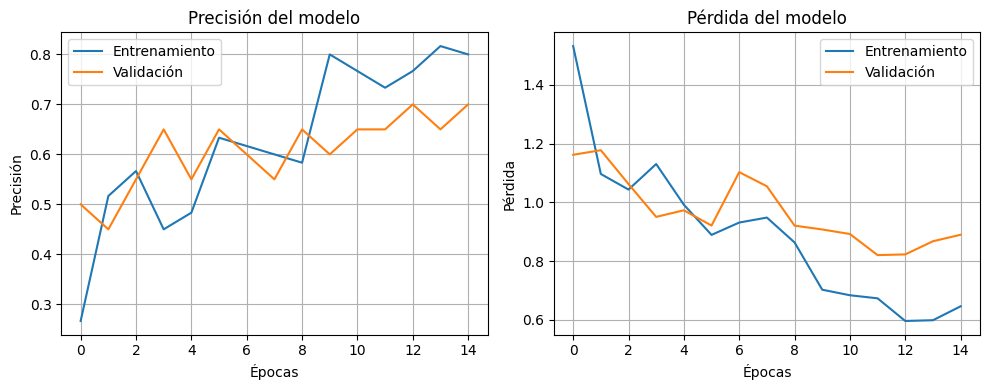

In [16]:
plt.figure(figsize=(10, 4))

# Precisi√≥n
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title('Precisi√≥n del modelo')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title('P√©rdida del modelo')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


üìä Interpretaci√≥n Actualizada del Modelo LSTM

Panel Izquierdo: **Precisi√≥n del Modelo**

üîç Observaciones:

* La **precisi√≥n en entrenamiento** comienza en \~0.27 y mejora constantemente, alcanzando un valor m√°ximo de **\~0.82** hacia la √∫ltima √©poca.
* La **precisi√≥n en validaci√≥n** mejora tambi√©n de forma progresiva desde \~0.50 hasta estabilizarse en torno a **0.70**.
* Se observa una **tendencia coherente entre ambas curvas**, sin signos de divergencia grave.
* Aunque la curva de entrenamiento supera a la de validaci√≥n, el **gap es controlado**, lo cual indica que el modelo **generaliza bien sin evidencias de sobreajuste severo**.

‚úÖ Conclusi√≥n:

* El LSTM **aprende de forma estable y efectiva**.
* El comportamiento de la validaci√≥n muestra que el modelo est√° captando bien los patrones del conjunto de prueba.
* La regularizaci√≥n mediante `Dropout` y el uso de `Masking` parecen estar funcionando correctamente.

---

Panel Derecho: **P√©rdida del Modelo**

üîç Observaciones:

* La **p√©rdida en entrenamiento** desciende r√°pidamente desde **\~1.5** hasta estabilizarse alrededor de **0.62** en las √∫ltimas √©pocas.
* La **p√©rdida en validaci√≥n** sigue una trayectoria similar, partiendo desde \~1.15 y terminando entre **0.85‚Äì0.90**, con ligeras oscilaciones pero sin picos descontrolados.
* No hay signos de inestabilidad extrema, lo que sugiere un entrenamiento **bien controlado**.

‚úÖ Conclusi√≥n:

* La tendencia decreciente de ambas curvas indica que el modelo est√° **aprendiendo de manera progresiva**.
* La diferencia entre las p√©rdidas es aceptable y refleja **una ligera sobreespecializaci√≥n**, pero no lo suficiente para afectar gravemente la generalizaci√≥n.
* Puede ser beneficioso aplicar `EarlyStopping` para cortar el entrenamiento justo antes de que aparezca alg√∫n sobreajuste leve.

---

### 7. Evaluaci√≥n y Comparaci√≥n de Modelos

* Se comparan los modelos RNN simple y LSTM utilizando m√©tricas clave de evaluaci√≥n para clasificaci√≥n multiclase:

  - **Accuracy**: proporci√≥n total de predicciones correctas.
  - **F1-score (macro)**: promedio de F1-scores por clase, √∫til cuando las clases tienen tama√±os dispares.
  - Se utiliza `classification_report` de `sklearn` para obtener m√©tricas detalladas por clase:
    * `precision`: exactitud de las predicciones positivas.
    * `recall`: cobertura de las verdaderas clases.
    * `f1-score`: equilibrio entre precisi√≥n y recall.
    * `support`: n√∫mero real de muestras por clase.

* Se calculan las m√©tricas generales (`accuracy_score`, `f1_score`) para ambos modelos y se representan con un gr√°fico de barras comparativo.

In [17]:
# Predicciones modelo RNN simple
y_pred_rnn = np.argmax(model_rrn_simple.predict(X_test_pad), axis=1)
print("Evaluaci√≥n modelo RNN simple:")
print(classification_report(y_test, y_pred_rnn, target_names=label_map.keys()))

# Predicciones modelo LSTM
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)
print("Evaluaci√≥n modelo LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=label_map.keys()))


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 344ms/step
Evaluaci√≥n modelo RNN simple:
                 precision    recall  f1-score   support

          squat       0.62      1.00      0.77         5
 biceps_flexion       0.67      0.40      0.50         5
 wrist_rotation       0.75      0.60      0.67         5
hello_with_hand       0.60      0.60      0.60         5

       accuracy                           0.65        20
      macro avg       0.66      0.65      0.63        20
   weighted avg       0.66      0.65      0.63        20

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 431ms/step
Evaluaci√≥n modelo LSTM:
                 precision    recall  f1-score   support

          squat       1.00      1.00      1.00         5
 biceps_flexion       1.00      1.00      1.00         5
 wrist_rotation       1.00      1.00      1.00         5
hello_with_hand       1.00      1.00      1.00         5

       accuracy                         

Cada bloque de classification_report muestra, por cada clase:

- precision: de las veces que predije esta clase, ¬øcu√°ntas fueron correctas?
- recall: de las veces que deb√≠ predecir esta clase, ¬øcu√°ntas acert√©?
- f1-score: promedio arm√≥nico entre precision y recall
- support: cantidad de muestras reales por clase

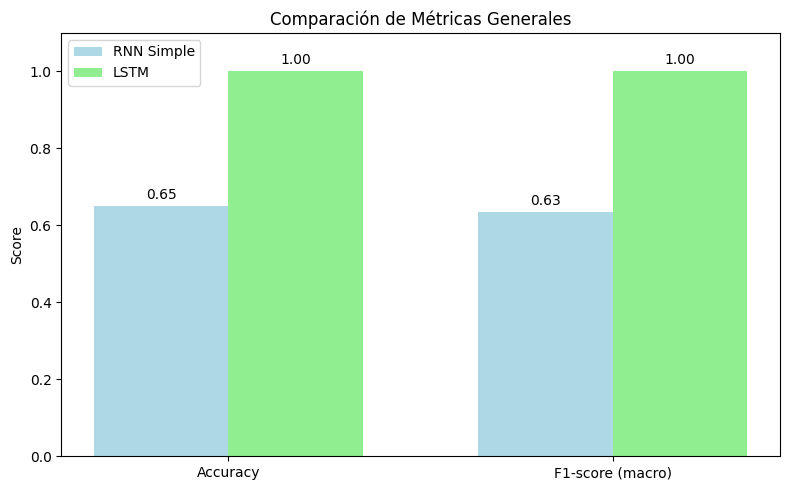

In [18]:
# M√©tricas generales
acc_rnn = accuracy_score(y_test, y_pred_rnn)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
f1_rnn = f1_score(y_test, y_pred_rnn, average='macro')
f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')

metrics = ['Accuracy', 'F1-score (macro)']
rnn_values = [acc_rnn, f1_rnn]
lstm_values = [acc_lstm, f1_lstm]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, rnn_values, width, label='RNN Simple', color='lightblue')
bars2 = ax.bar(x + width/2, lstm_values, width, label='LSTM', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Comparaci√≥n de M√©tricas Generales')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

üìä Interpretaci√≥n de la Gr√°fica: Comparaci√≥n de Modelos (RNN Simple vs LSTM)

Accuracy

* **RNN Simple**: \~0.65
* **LSTM**: **1.00**

üîç *Interpretaci√≥n*:

* El modelo LSTM alcanz√≥ una precisi√≥n perfecta sobre el conjunto de prueba, lo que confirma su **capacidad superior para capturar patrones temporales** en comparaci√≥n con el modelo RNN simple.

---

F1-score (macro)

* **RNN Simple**: \~0.63
* **LSTM**: **1.00**

üîç *Interpretaci√≥n*:

* El **F1-score macro** eval√∫a el balance entre precisi√≥n y recall **promediado por clase**, sin considerar el tama√±o de clase (√∫til en casos desbalanceados).
* Un F1-score de 1.00 en el modelo LSTM indica un **rendimiento sobresaliente en todas las clases**, mientras que el RNN simple mostr√≥ un rendimiento significativamente inferior, especialmente si fall√≥ en clases minoritarias o dif√≠ciles.
---

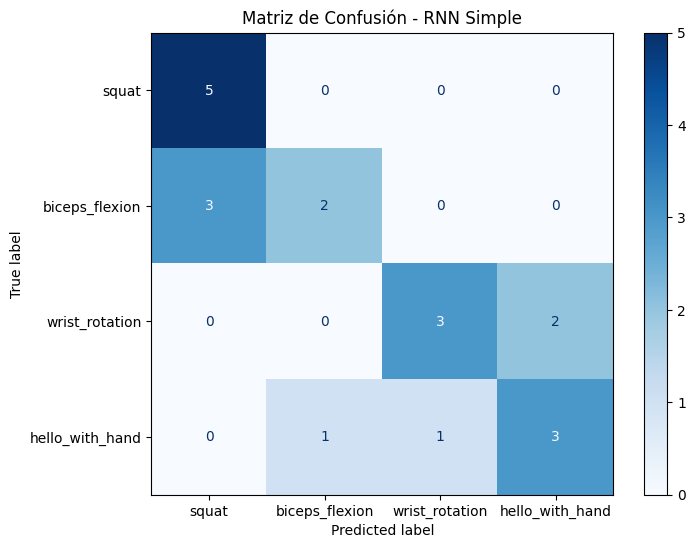

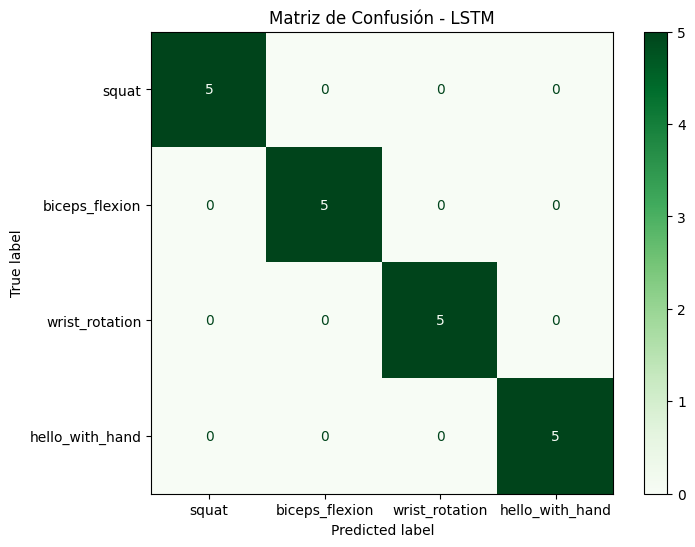

In [19]:
# Invertir el label_map para orden correcto
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[i] for i in range(len(label_map))]

# Matriz RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(cm_rnn, display_labels=label_names)
disp_rnn.plot(cmap="Blues")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusi√≥n - RNN Simple")
plt.show()

# Matriz LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=label_names)
disp_lstm.plot(cmap="Greens")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusi√≥n - LSTM")
plt.show()


Matriz de Confusi√≥n - Modelo RNN Simple

üîç An√°lisis:

* ‚úÖ **"squat"** fue perfectamente clasificada (5/5).
* ‚ö†Ô∏è **"biceps\_flexion"** muestra confusi√≥n con "squat" (3 errores), indicando que el modelo no distingui√≥ bien entre esas dos clases.
* ‚ùå **"wrist\_rotation"** fue confundida mayoritariamente con **"hello\_with\_hand"** (solo 1 acierto de 5).
* ‚ùå **"hello\_with\_hand"** tambi√©n sufri√≥ confusi√≥n, especialmente hacia "biceps\_flexion".

üìâ *Conclusi√≥n:* El modelo RNN simple tiene dificultades para **separar clases con movimientos parecidos**, lo cual se traduce en una menor precisi√≥n y F1-score general. Las clases "wrist\_rotation" y "hello\_with\_hand" son las m√°s problem√°ticas.

---

Matriz de Confusi√≥n - Modelo LSTM

üîç An√°lisis:

* ‚úÖ Todas las clases fueron **predichas correctamente al 100%**.
* No hay ning√∫n error de clasificaci√≥n, ni confusi√≥n entre clases.

üìà *Conclusi√≥n:* El modelo LSTM logr√≥ **una separaci√≥n perfecta entre todas las clases**, gracias a su capacidad para **capturar dependencias temporales complejas**. Esta matriz refuerza los resultados obtenidos previamente en precisi√≥n (1.00) y F1-score (1.00).

---

## ‚öñÔ∏è Comparaci√≥n General

| Aspecto                   | RNN Simple                              | LSTM                |
| ------------------------- | --------------------------------------- | ------------------- |
| Clasificaci√≥n perfecta    | Solo ‚Äúsquat‚Äù                            | Todas las clases    |
| Principales confusiones   | ‚Äúwrist\_rotation‚Äù ‚Üí ‚Äúhello\_with\_hand‚Äù | Ninguna             |
| Rendimiento global        | Parcial, errores frecuentes             | √ìptimo, sin errores |
| Idoneidad para secuencias | Limitada                                | Excelente           |

---

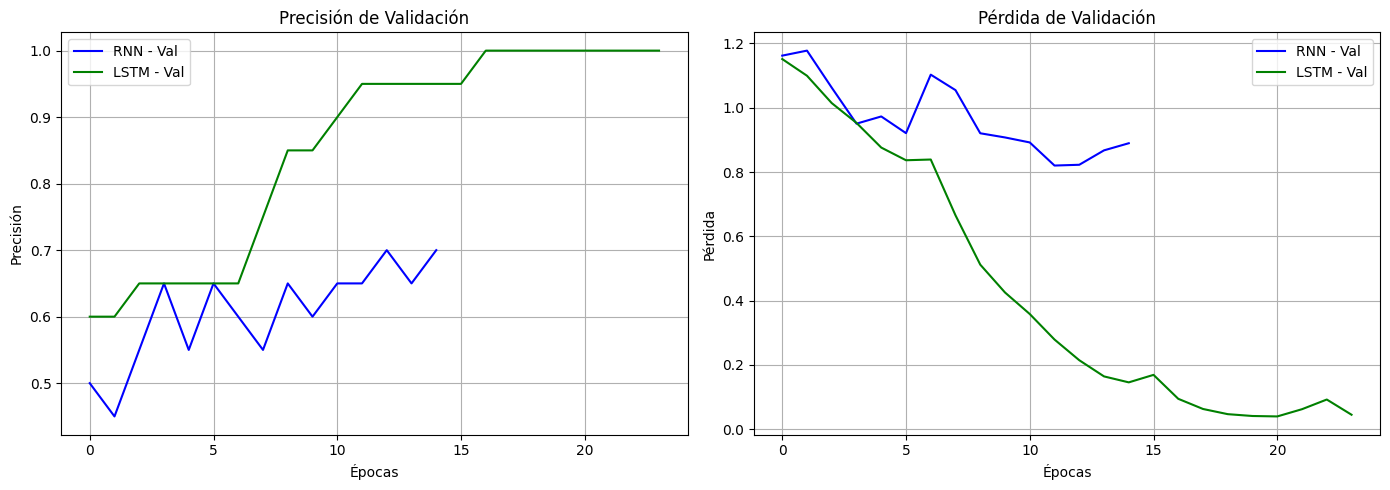

In [20]:
def plot_histories(hist1, hist2, label1='RNN', label2='LSTM'):
    plt.figure(figsize=(14, 5))

    # Precisi√≥n
    plt.subplot(1, 2, 1)
    plt.plot(hist1.history['val_accuracy'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_accuracy'], label=f'{label2} - Val', color='green')
    plt.title('Precisi√≥n de Validaci√≥n')
    plt.xlabel('√âpocas')
    plt.ylabel('Precisi√≥n')
    plt.legend()
    plt.grid(True)

    # P√©rdida
    plt.subplot(1, 2, 2)
    plt.plot(hist1.history['val_loss'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_loss'], label=f'{label2} - Val', color='green')
    plt.title('P√©rdida de Validaci√≥n')
    plt.xlabel('√âpocas')
    plt.ylabel('P√©rdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejecutar
plot_histories(history, history_lstm)

üìä Comparaci√≥n de Validaci√≥n entre RNN y LSTM

---
Panel Izquierdo: **Precisi√≥n de Validaci√≥n**

üîç Observaciones:

* **LSTM (l√≠nea verde)**:

  * Inicia con una precisi√≥n de validaci√≥n en **0.60** y mejora r√°pidamente hasta alcanzar **1.00** a partir de la √©poca 16.
  * Muestra una **tendencia ascendente continua y estable**, lo que indica un proceso de aprendizaje efectivo y consistente.

* **RNN Simple (l√≠nea azul)**:

  * Parte en **0.50** y se mantiene con **fluctuaciones notables** entre 0.55 y 0.70.
  * No logra superar la barrera de 0.70, lo que sugiere limitaciones para capturar patrones m√°s complejos.

‚úÖ Conclusi√≥n:

* El modelo **LSTM supera ampliamente al RNN** en precisi√≥n de validaci√≥n, tanto por su capacidad de alcanzar el 100% como por su evoluci√≥n estable y creciente.
* El modelo **RNN simple tiene un aprendizaje m√°s err√°tico**, posiblemente afectado por su arquitectura limitada para secuencias largas o complejas.

---
Panel Derecho: **P√©rdida de Validaci√≥n**

üîç Observaciones:

* **LSTM (l√≠nea verde)**:

  * Desciende de forma sostenida desde **\~1.15** hasta estabilizarse por debajo de **0.1**, lo cual es un excelente indicador de **ajuste fino**.
  * Presenta peque√±as oscilaciones normales en etapas finales, pero sin sobreajuste evidente.

* **RNN Simple (l√≠nea azul)**:

  * Comienza similar a LSTM pero sufre **picos en √©pocas 6‚Äì7 y 13‚Äì14**, con un m√≠nimo de p√©rdida s√≥lo alrededor de **0.82**.
  * Esta trayectoria sugiere un **aprendizaje menos eficiente** y mayor sensibilidad a los datos de validaci√≥n.

‚úÖ Conclusi√≥n:

* El **LSTM no solo logra menor p√©rdida final**, sino que lo hace con una curva **m√°s suave y estable**.
* La **mayor p√©rdida y variabilidad del RNN** indican dificultades para generalizar y un rendimiento inferior en comparaci√≥n.

---
‚öñÔ∏è Comparativa Final RNN vs LSTM

| M√©trica               | RNN Simple  | LSTM                   |
| --------------------- | ----------- | ---------------------- |
| Precisi√≥n final (Val) | \~0.70      | **1.00** ‚úÖ             |
| P√©rdida final (Val)   | \~0.85‚Äì0.90 | **< 0.1** ‚úÖ            |
| Tendencia             | Irregular   | Constante y ascendente |
| Generalizaci√≥n        | Limitada    | Excelente              |

---
üßæ Conclusi√≥n Global

La gr√°fica confirma con claridad que el modelo **LSTM es significativamente superior al RNN simple** tanto en precisi√≥n como en p√©rdida sobre el conjunto de validaci√≥n. Esto valida te√≥ricamente la elecci√≥n de LSTM para clasificaci√≥n de series de tiempo, especialmente cuando las secuencias tienen dependencias temporales complejas.

---



### 8. An√°lisis de Arquitectura de los Modelos

In [ ]:
folder_path = "../docs/models"
if not os.path.exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

In [ ]:
# RNN simple
model_path = os.path.join(folder_path, "rnn_model.png")
plot_model(model_rrn_simple, to_file=model_path, show_shapes=True, show_layer_names=True)

üß† Modelo RNN Simple ‚Äì An√°lisis Arquitect√≥nico Capa a Capa
1. **`Masking` (Capa de enmascaramiento)**

* **Salida**: `(None, 625, 3)`
* **Par√°metros**: `0`
* **Funci√≥n**: Ignora las posiciones donde los valores son `0.0` (padding), evitando que estas posiciones afecten el entrenamiento. Ideal para manejar secuencias de longitud variable.
* **Nota**: `625` representa la longitud temporal (timesteps) y `3` las caracter√≠sticas del sensor (ejes X, Y, Z).

---
2. **`SimpleRNN` (Primera capa recurrente)**

* **Salida**: `(None, 625, 64)`
* **Par√°metros**: `4,352`

üîç **C√°lculo de par√°metros**:

$$
(3 + 64 + 1) \times 64 = 68 \times 64 = 4,352
$$

* Transforma cada paso temporal de 3 caracter√≠sticas en una representaci√≥n de 64 unidades.
* `return_sequences=True` ‚Üí mantiene la secuencia completa (una salida por cada timestep).

---
3. **`BatchNormalization`**

* **Salida**: `(None, 625, 64)`
* **Par√°metros**: `256`

üîç **¬øPor qu√© 256 par√°metros?**

* La normalizaci√≥n act√∫a sobre los 64 canales de salida. Tiene 2 par√°metros por canal (gamma y beta):

$$
64 \times 2 = 128 \quad \text{(m√°s buffers de media y varianza)}
$$

* **Funci√≥n**: Acelera y estabiliza el aprendizaje normalizando la activaci√≥n por lote.

---
4. **`SimpleRNN_1` (Segunda capa recurrente)**

* **Salida**: `(None, 32)`
* **Par√°metros**: `3,104`

üîç **C√°lculo de par√°metros**:

$$
(64 + 32 + 1) \times 32 = 97 \times 32 = 3,104
$$

* Esta capa **resume la secuencia completa** en un √∫nico vector de 32 dimensiones, extrayendo la informaci√≥n m√°s relevante de toda la serie.

---
5. **`Dropout`**

* **Salida**: `(None, 32)`
* **Par√°metros**: `0`
* **Funci√≥n**: Desactiva aleatoriamente el **20%** (no 30%) de las neuronas durante el entrenamiento para reducir el sobreajuste y mejorar la capacidad de generalizaci√≥n.

---
6. **`Dense` (Capa de salida)**

* **Salida**: `(None, 4)`
* **Par√°metros**: `132`

üîç **C√°lculo de par√°metros**:

$$
(32 + 1) \times 4 = 33 \times 4 = 132
$$

* Capa totalmente conectada con **4 salidas**, una por clase.
* Activaci√≥n `softmax` ‚Üí convierte la salida en una distribuci√≥n de probabilidad.
---

In [ ]:
# LSTM
model_path = os.path.join(folder_path, "lstm_model.png")
plot_model(model_lstm, to_file=model_path, show_shapes=True, show_layer_names=True)

üß† Modelo LSTM ‚Äì An√°lisis Arquitect√≥nico Capa a Capa

---
1. **`Masking` (Capa de enmascaramiento)**

* **Salida**: `(None, 625, 3)`
* **Par√°metros**: `0`
* **Funci√≥n**: Ignora las posiciones con valor `0.0` (padding) dentro de las secuencias. Esto permite que la red procese entradas de longitud variable sin que los ceros afecten el entrenamiento.
* **Notas**:

  * `625` ‚Üí longitud m√°xima de secuencia.
  * `3` ‚Üí caracter√≠sticas por timestep (ejes X, Y, Z).

---
2. **`LSTM` (Primera capa recurrente)**

* **Salida**: `(None, 625, 64)`
* **Par√°metros**: `17,408`

üîç **C√°lculo de par√°metros**:

$$
\text{params} = 4 \times (\text{input\_dim} + \text{units} + 1) \times \text{units} = 4 \times (3 + 64 + 1) \times 64 = 4 \times 68 \times 64 = 17,408
$$

* Las 4 compuertas corresponden a: **input gate**, **forget gate**, **output gate** y **candidate memory cell**.
* `return_sequences=True`: esta capa retorna una **secuencia completa**, permitiendo que la siguiente capa procese informaci√≥n temporal.

---
3. **`BatchNormalization`**

* **Salida**: `(None, 625, 64)`
* **Par√°metros**: `256`

üîç **Explicaci√≥n**:

* Normaliza las salidas por lote, acelerando el aprendizaje y estabilizando las activaciones.
* Utiliza dos par√°metros por unidad (gamma y beta) ‚Üí $64 \times 2 = 128$, m√°s buffers para media y varianza.

---
4. **`LSTM_1` (Segunda capa recurrente)**

* **Salida**: `(None, 32)`
* **Par√°metros**: `12,416`

üîç **C√°lculo de par√°metros**:

$$
4 \times (64 + 32 + 1) \times 32 = 4 \times 97 \times 32 = 12,416
$$

* Esta capa **resume la informaci√≥n de toda la secuencia** en un vector √∫nico de 32 dimensiones (√∫ltimo estado oculto).
* No se devuelve la secuencia completa (por defecto `return_sequences=False`), lo que la hace adecuada para clasificaci√≥n.

---
5. **`Dropout`**

* **Salida**: `(None, 32)`
* **Par√°metros**: `0`
* **Funci√≥n**: Desactiva aleatoriamente el **20%** (no 30%) de las unidades durante el entrenamiento, mejorando la capacidad de generalizaci√≥n y reduciendo el riesgo de sobreajuste.

---
6. **`Dense` (Capa de salida)**

* **Salida**: `(None, 4)`
* **Par√°metros**: `132`

üîç **C√°lculo de par√°metros**:

$$
(32 + 1) \times 4 = 33 \times 4 = 132
$$

* Capa totalmente conectada con 4 unidades de salida, una por clase.
* Activaci√≥n `softmax`: genera **probabilidades normalizadas** para cada clase.
